Build a baseline model using the weather station data (this approach used all days in 2018 since the data was available).


Then use the model to make predictions for the ENVI-met(micro-climate) data for that specific day and compare it to model predictions using weather station data also for the same day.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 1. Import

In [173]:
import pandas as pd
import numpy as np
import pathlib
import pickle
import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime
import seaborn as sns

# train-test split
from sklearn.model_selection import train_test_split

# 2. Load All Data

In [174]:
# LIMITED DATA
Bldg_Lim = []

# Read all building data and append to list
for path in pathlib.Path("./Data/microclimate_model/Combined/dataset3").iterdir():
        if path.is_file():
            current_file = pd.read_csv(path)
            current_file = current_file.drop(columns=['Unnamed: 0'])
            Bldg_Lim.append(current_file)

# BIG DATA
Bldg_Big = []

# Read all building data and append to list
for path in pathlib.Path("./Data/NN_big_data").iterdir():
        if path.is_file():
            current_file = pd.read_csv(path)
            current_file = current_file.drop(columns=['Unnamed: 0'])
            Bldg_Big.append(current_file)

## 2.1 Preprocessing

1. Adding Month, Hour, and Minute to limited data
2. Removing hours out of ENVI-met accuracy range (after 9 pm) for limited data
3. Add CHWTON/SQFT to columns using condition area for each building taken from
    https://fdm-apps.asu.edu/UFRM/FDS/FacilityData.aspx
4. Drop na rows in limited data (some data points from campus metabolism not available)
5. Drop 'index' column and rename 'rel humid' to 'rel hum' for big data
6. Calculate and create new column for absolute humidity using equations from https://www.hatchability.com/Vaisala.pdf which can be validated using https://planetcalc.com/2167/

In [175]:
## LIMITED DATA ##
# Create Month, Hour, and Minute column for all dataframes in list and drop unnecessary columns
for i in range(len(Bldg_Lim)):
    Bldg_Lim[i].Date_Time = pd.to_datetime(Bldg_Lim[i].Date_Time)
    Bldg_Lim[i]['Month'] = Bldg_Lim[i].Date_Time.dt.month
    Bldg_Lim[i]['Hour'] = Bldg_Lim[i].Date_Time.dt.hour
    Bldg_Lim[i]['Minute'] = Bldg_Lim[i].Date_Time.dt.minute
    Bldg_Lim[i]['Day'] = Bldg_Lim[i].Date_Time.dt.day
    Bldg_Lim[i] = Bldg_Lim[i].drop(columns = ['Date_Time'])

# Remove data after 9pm
for i in range(len(Bldg_Lim)):
    Bldg_Lim[i] = Bldg_Lim[i][(Bldg_Lim[i]['Hour'] <= 20) & (Bldg_Lim[i]['Hour'] > 0)]

# Add Column: CHWTON/Condition Area (SqFt) or ['CHWTON/SQFT']
cond_area = {'Noble Library':88658,'Biodesign B':132215,'Biodesign C':145410,
             'Biodesign A':133016,'Psychology':69864,'Goldwater':165237,'Schwada COB':99857,
             'ISTB 2':41404,'Bulldog Hall':68067,'ISTB 4':231646,'Psychology North':43034}
for i in range(len(Bldg_Lim)):
    if Bldg_Lim[i]['bldgname'][0] in cond_area:
        Bldg_Lim[i]['CHWTON/SQFT'] = Bldg_Lim[i]['CHWTON'] / cond_area[Bldg_Lim[i]['bldgname'][0]]

# Drop NA rows in data
for i in range(len(Bldg_Lim)):
  Bldg_Lim[i] = Bldg_Lim[i].dropna()
  Bldg_Lim[i] = Bldg_Lim[i].reset_index(drop=True)

## BIG DATA ##
# Rename 'Rel Humid' to 'Rel Hum' and drop 'index' column
for i in range(len(Bldg_Big)):
  Bldg_Big[i] = Bldg_Big[i].rename(columns = {'Rel Humid': 'Rel Hum'})
  Bldg_Big[i] = Bldg_Big[i].drop(columns=['index'])

In [176]:
# Check if NA in data
for i in range(len(Bldg_Lim)):
  null_data = Bldg_Lim[i][Bldg_Lim[i].isnull().any(axis=1)]
  print(null_data)

Empty DataFrame
Columns: [bldgname, Date, Time, Air Temp, Rel Hum, KW, CHWTON, HTmmBTU, Month, Hour, Minute, Day, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Air Temp, Rel Hum, KW, CHWTON, HTmmBTU, Month, Hour, Minute, Day, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Air Temp, Rel Hum, KW, CHWTON, HTmmBTU, Month, Hour, Minute, Day, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Air Temp, Rel Hum, KW, CHWTON, HTmmBTU, Month, Hour, Minute, Day, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Air Temp, Rel Hum, KW, CHWTON, HTmmBTU, Month, Hour, Minute, Day, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Air Temp, Rel Hum, KW, CHWTON, HTmmBTU, Month, Hour, Minute, Day, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date, Time, Air Temp, Rel Hum, KW, CHWTON, HTmmBTU, Month, Hour, Minute, Day, CHWTON/SQFT]
Index: []
Empty DataFrame
Columns: [bldgname, Date,

In [177]:
# Constants
P_c = 220640
T_c = 647.096
C_1 = -7.85951783
C_2 = 1.84408259
C_3 =  -11.7866497
C_4 = 22.6807411
C_5 = -15.9618719
C_6 = 1.80122502
C = 2.16679

# Convert Rel Hum to Abs Hum for Limited Data
for i in range(len(Bldg_Lim)):
    T_i = Bldg_Lim[i]['Air Temp']
    RH = Bldg_Lim[i]['Rel Hum']/100
    T = T_i + 273.15
    v = 1 - (T/T_c)
    x = (T_c/T)*((C_1*v) + (C_2*np.power(v, 1.5)) + (C_3*np.power(v, 3)) 
                 + (C_4*np.power(v, 3.5)) + (C_5*np.power(v, 4)) + (C_6*np.power(v, 7.5))) 
    P_ws = np.exp(x)*P_c
    P_w = P_ws*RH
    A = C*P_w*100/T
    Bldg_Lim[i]['Abs Hum'] = A

# Convert Rel Hum to Abs Hum for Big Data
for i in range(len(Bldg_Big)):
    T_i = Bldg_Big[i]['Air Temp']
    RH = Bldg_Big[i]['Rel Hum']/100
    T = T_i + 273.15
    v = 1 - (T/T_c)
    x = (T_c/T)*((C_1*v) + (C_2*np.power(v, 1.5)) + (C_3*np.power(v, 3)) 
                 + (C_4*np.power(v, 3.5)) + (C_5*np.power(v, 4)) + (C_6*np.power(v, 7.5))) 
    P_ws = np.exp(x)*P_c
    P_w = P_ws*RH
    A = C*P_w*100/T
    Bldg_Big[i]['Abs Hum'] = A

In [178]:
## Rearrange Columns

# For Limited Data
for i in range(len(Bldg_Lim)):
    cols = ['bldgname','Date','Time','Month','Day','Hour','Minute','Air Temp','Abs Hum', 'Rel Hum','KW','CHWTON','CHWTON/SQFT']
    Bldg_Lim[i] = Bldg_Lim[i][cols]

# For Big Data
for i in range(len(Bldg_Big)):
    cols = ['bldgname','Month','Day','Hour','Minute','Air Temp','Abs Hum', 'Rel Hum','KW','CHWTON','CHWTON/SQFT']
    Bldg_Big[i] = Bldg_Big[i][cols]

# 3. Single Building Analysis - Big Data

## 3.1 Select Building

In [70]:
# Ask user to select building
for i in range(len(Bldg_Big)):
    print(i, Bldg_Big[i]['bldgname'][0])

bldgnum_B = int(input("Enter the number of the building from the list above: "))

Bldg_Big[bldgnum_B]

0 Goldwater
1 Bulldog Hall
2 ISTB 2
3 Psychology North
4 Schwada COB
5 Biodesign C
6 Biodesign A
7 Psychology
8 Biodesign B
9 Noble Library
10 ISTB 4
Enter the number of the building from the list above: 10


,bldgname,Month,Day,Hour,Minute,Air Temp,Abs Hum,Rel Hum,KW,CHWTON,CHWTON/SQFT
0,ISTB 4,1,1,0,0,11.0,4.028567,40.24,890.33,70.48,0.000304
1,ISTB 4,1,1,0,15,11.0,4.028567,40.24,891.28,59.73,0.000258
2,ISTB 4,1,1,0,30,10.0,4.042106,43.01,886.57,64.01,0.000276
3,ISTB 4,1,1,0,45,9.0,4.056162,46.00,886.66,63.49,0.000274
4,ISTB 4,1,1,1,0,9.0,4.056162,46.00,880.12,68.87,0.000297
...,...,...,...,...,...,...,...,...,...,...,...
34618,ISTB 4,12,31,22,0,6.0,6.773487,93.30,951.10,69.14,0.000298
34619,ISTB 4,12,31,22,15,5.0,6.797015,100.00,952.58,70.95,0.000306
34620,ISTB 4,12,31,22,30,5.0,6.797015,100.00,937.86,68.62,0.000296
34621,ISTB 4,12,31,22,45,6.0,6.773487,93.30,941.16,70.36,0.000304


## 3.2 EDA

### 3.2.1 Boxplots

In [ ]:
# Show df columns to select for boxplot
x = Bldg_Big[bldgnum_B].columns
for i in range(len(x)):
    print(i, x[i])
# Get column name from user
colname = int(input("Enter the number of the following data columns to graph boxplot: "))
# Plot
print('\n',Bldg_Big[bldgnum_B]['bldgname'][0])
Bldg_Big[bldgnum_B].boxplot(by='Month', column=x[colname], grid = False, figsize = (8,8))

### 3.2.2 Time Series

In [ ]:
### will work on create Date and Time column for big data to visualize vs Limited Data

# 4. Single Building Analysis - Limited Data

## 4.1 Select Building

In [71]:
# Ask user to select building
for i in range(len(Bldg_Lim)):
    print(i, Bldg_Lim[i]['bldgname'][0])

bldgnum_L = int(input("Enter the number of the building from the list above: "))

Bldg_Lim[bldgnum_L].head()

0 Goldwater
1 Bulldog Hall
2 ISTB 2
3 Psychology North
4 Schwada COB
5 Biodesign C
6 Biodesign A
7 Psychology
8 Biodesign B
9 Noble Library
10 ISTB 4
Enter the number of the building from the list above: 10


,bldgname,Date,Time,Month,Day,Hour,Minute,Air Temp,Abs Hum,Rel Hum,KW,CHWTON,CHWTON/SQFT
0,ISTB 4,2018-05-16,05:00,5,16,5,0,25.012220,4.430433,19.218981,902.76,337.88,0.001459
1,ISTB 4,2018-05-16,05:15,5,16,5,15,24.671093,4.864263,21.510339,909.39,343.41,0.001482
2,ISTB 4,2018-05-16,05:30,5,16,5,30,24.495274,4.786310,21.376736,904.81,348.91,0.001506
3,ISTB 4,2018-05-16,05:45,5,16,5,45,24.375078,4.778235,21.486126,893.55,328.88,0.001420
4,ISTB 4,2018-05-16,06:00,5,16,6,0,24.257700,4.793644,21.699019,892.93,329.80,0.001424


## 4.2 EDA

### 4.2.1 Boxplots

In [ ]:
# Show df columns to select for boxplot
x = Bldg_Lim[bldgnum_L].columns
for i in range(len(x)):
    print(i, x[i])
# Get column name from user
colname = int(input("Enter the number of the following data columns to graph boxplot: "))
# Plot
print('\n',Bldg_Lim[bldgnum_L]['bldgname'][0])
Bldg_Lim[bldgnum_L].boxplot(by='Hour', column=x[colname], grid = False, figsize = (8,8))

### 4.2.2 Time Series

Month available:<br>
May: 16, 23 <br>
June: 7, 8, 20, 21, 25<br>
August: 3<br>
September: 11, 29<br>

In [ ]:
import datetime
# Get month number for plotting
m_num = int(input("Enter month number: "))
# Convert to datetime to get month name
datetime_object = datetime.datetime.strptime(str(m_num), "%m")
m_name = datetime_object.strftime("%b")

# Plot only if entered month is in data
if m_num in Bldg_Lim[bldgnum_L]['Month'].unique():
    from datetime import datetime
    # Assign new df for chosen month
    plotdf = pd.DataFrame(Bldg_Lim[bldgnum_L][(Bldg_Lim[bldgnum_L]['Month'] == m_num)])
    # Show number of days found in chosen month
    x = plotdf['Date'].unique()
    print("\n", len(x), "day(s) found in", m_name, "\n")
    # Show all columns to select y-axis for plotting
    cols = plotdf.columns
    for i in range(len(cols)):
        print(i, cols[i])
    # Get y-axis for plotting
    y_ax = int(input('Enter y-axis from column list above: '))
    y_ax = cols[y_ax]
    for i in range(len(x)):
        datetime_object = datetime.strptime(x[i], '%Y-%m-%d')
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        d = days[datetime_object.weekday()]
        plotdf1 = plotdf[(plotdf['Date']==x[i])]
        plotdf1.plot(x = 'Time', y = y_ax, grid = False, figsize = (8,8), title = x[i] + ' ' + d)
else:
    print("Month number not in data")

### 4.2.3 Correlation Matrix

In [ ]:
corr_pd = pd.DataFrame(Bldg_Lim[bldgnum_L][['Air Temp','Abs Hum', 'Rel Hum','KW', 'CHWTON/SQFT']])
corrMatrix = corr_pd.corr()
sns.heatmap(corrMatrix)

# 5. Train Models on both datasets 

## 5.1 Define Generalized Model Functions

In [181]:
#using single layer ANN. Model Parameters: hidden layer- 10 neurons, output layer- 1 neuron
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.keras import initializers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from tensorflow.keras import backend as K
def prepare_data(dataset):
    Y = dataset['CHWTON/SQFT']
    X = dataset[['Air Temp', 'Abs Hum']]
    Y= Y.values.reshape(-1, 1)
    # create scaler
    scaler1 = StandardScaler()
    X_scaled = scaler1.fit_transform(X)
    # #do for output variables
    scaler2 = StandardScaler()
    Y_scaled = scaler2.fit_transform(Y)
    X_scaled = np.asarray(X_scaled).astype('float32')
    Y_scaled = np.asarray(Y_scaled).astype('float32')
    return X_scaled,Y_scaled

def huber_loss(y_true, y_pred, clip_delta=1.0):
    error = y_true - y_pred
    cond  = tf.keras.backend.abs(error) < clip_delta
    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)
    return tf.where(cond, squared_loss, linear_loss)

'''
 ' Same as above but returns the mean loss.
'''
def huber_loss_mean(y_true, y_pred, clip_delta=1.0):
    return tf.keras.backend.mean(huber_loss(y_true, y_pred, clip_delta))

def define_model(activation_type, hidden_layers, loss, kernel_initializer='he_normal', bias_initializer='he_normal'):
    model = Sequential()
    if activation_type == 'leaky_relu':
        model.add(Dense(10, input_dim=2, kernel_initializer='he_normal'))
        model.add(LeakyReLU(alpha=0.1))
        for i in range(0,(hidden_layers-2)):
            model.add(Dense(8))
            model.add(LeakyReLU(alpha=0.1))
        model.add(Dense(16))
        model.add(Dense(1, activation='linear'))
    else:
        model.add(Dense(10, input_dim=2, kernel_initializer='he_normal', bias_initializer='he_normal', activation=activation_type))
        for i in range(0,(hidden_layers-2)):
            model.add(Dense(8, activation=activation_type))
        model.add(Dense(12, activation=activation_type))
        model.add(Dense(1, activation='linear'))
    model.compile(loss= loss, optimizer='adam', metrics = ['mse','mae'])
#     model.summary()
    return model
def fine_tune(model,loss):
    model.trainable = True
    fine_tune_at = 2
    for layer in model.layers[:fine_tune_at]:
      layer.trainable =  False
    model.compile(loss=loss, optimizer='adam', metrics = ['mse','mae'])
    return model
def plot_curve(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
def evaluate(model,X,Y):
    #evaluate on test dataset, add evaluation parameters
    Y_preds = model.predict(X)
    RMSE = np.sqrt(metrics.mean_squared_error(Y, Y_preds))
    R2_score = metrics.r2_score(Y, Y_preds)
#     test_loss = model.evaluate(X, Y)
    return RMSE, R2_score

## 5.2 Prepare Data for feeding into training loop

In [142]:
# Limited Data
X_limited,Y_limited = prepare_data(Bldg_Lim[bldgnum_L])
X_limited_train, X_limited_test, Y_limited_train,Y_limited_test = train_test_split(X_limited,Y_limited , test_size=0.2, random_state=20)
X,Y = prepare_data(Bldg_Big[bldgnum_B])
X_train, X_test, Y_train,Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

In [143]:
# X_limited_test

## 5.3 Hyperparameter Tuning experiments

In [185]:
# eval_func = []
# max_R2 = -inf
# for func in activation_functions:
#     eval_func_layers = []
#     for hl in no_hidden_layers:
#         eval_func_loss = []
#         for loss in loss_functions:
#             model = define_model(func,hl,loss)
#             history = model.fit(X_train, Y_train, batch_size=128, epochs=150,  validation_split=0.2, verbose=0)
#             RMSE, R2 = evaluate(base_model, X_test, Y_test)
#             RMSE_base_model, R2_base_model = evaluate(base_model, X_limited_test,Y_limited_test)
#             eval_func_loss.append(R2)
#         eval_func_layers.append(eval_func_loss)
#     eval_func.append(eval_func_layers)
# print(eval_func)   
# tab = pd.DataFrame(eval_func, activation_functions, no_hidden_layers_headings,loss_functions_headings)
# print(tab)

def tune_multiple_buildings():
    activation_functions = ['relu','elu','selu','leaky_relu','tanh']
    no_hidden_layers = [1,3,5]
    loss_functions = ['mean_squared_error','mean_absolute_error','mean_absolute_percentage_error',huber_loss,huber_loss_mean]
#     loss_functions_headings = ['mean_squared_error','mean_absolute_error','mean_absolute_percentage_error','huber_loss','huber_loss_mean']
    ### Create dataframe and add building names ###
    rf_optimal_model = pd.DataFrame(columns = {"bldgname", "R2_score_bigdata_best","R2_score_limiteddata_best", 'Activation Function','No of hidden layers', 'Loss function' })
    for i in range(len(Bldg_Lim)):
        rf_optimal_model = rf_optimal_model.append({'bldgname': Bldg_Lim[i]['bldgname'].unique()[0]}, ignore_index=True)
    rf_optimal_model.fillna(5)
    ### Train over all hyperparameters over all buildings ###
    for i in range(len(Bldg_Lim)):
        max = 0
        # drop na values if in dataframe
        if (Bldg_Lim[i].isnull().values.any() == True):
            Bldg_Lim[i] = Bldg_Lim[i].dropna()
        building_name = Bldg_Lim[i]['bldgname'][0] 
        print("Find parameters for "+ building_name)
        optimal_hyperparameters=[]
        # Limited Data
        X_limited,Y_limited = prepare_data(Bldg_Lim[i])
        X_limited_train, X_limited_test, Y_limited_train,Y_limited_test = train_test_split(X_limited,Y_limited , test_size=0.1, random_state=20)
        #Big Data
        X,Y = prepare_data(Bldg_Big[i])
        X_train, X_test, Y_train,Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)
        for func in activation_functions:
            for hl in no_hidden_layers:
                for loss in loss_functions:
                    print("Results for hyperparameters:Activation Fn: "+ func+ " #hidden_layers: "+ str(hl) + " loss function: "+ str(loss))
                    model = define_model(func,hl,loss)
                    history = model.fit(X_train, Y_train, batch_size=128, epochs=150,  validation_split=0.2, verbose=0)
                    RMSE, R2 = evaluate(model, X_test, Y_test)
                    RMSE_base_model, R2_base_model = evaluate(model, X_limited_test,Y_limited_test)
                    print(R2_base_model)
                    if(R2_base_model>max):
                        max = R2_base_model
                        print("Updated hyperparameters for building: "+ building_name +"max_R2:"+str(max)+": Activation Fn: "+ str(func)+ " #hidden_layers: "+ str(hl) + " loss function: "+ str(loss))
                        rf_optimal_model["R2_score_bigdata_best"][i]=R2
                        rf_optimal_model["R2_score_limiteddata_best"][i]=R2_base_model
                        rf_optimal_model["Activation Function"][i]=func
                        rf_optimal_model["No of hidden layers"][i]=hl
                        rf_optimal_model["Loss function"][i]=loss
    rf_optimal_model = rf_optimal_model[["bldgname", "R2_score_bigdata_best","R2_score_limiteddata_best", 'Activation Function','No of hidden layers', 'Loss function']]
    return rf_optimal_model
optimal_model_buildings = tune_multiple_buildings()
display(optimal_model_buildings)


Find parameters for Goldwater
Results for hyperparameters:Activation Fn: relu #hidden_layers: 1 loss function: mean_squared_error
0.9317104992895349
Updated hyperparameters for building: Goldwatermax_R2:0.9317104992895349: Activation Fn: relu #hidden_layers: 1 loss function: mean_squared_error
Results for hyperparameters:Activation Fn: relu #hidden_layers: 1 loss function: mean_absolute_error
0.920965073409049
Results for hyperparameters:Activation Fn: relu #hidden_layers: 1 loss function: mean_absolute_percentage_error
0.8518559000709084
Results for hyperparameters:Activation Fn: relu #hidden_layers: 1 loss function: <function huber_loss at 0x7f2014467e60>
0.9287241403581608
Results for hyperparameters:Activation Fn: relu #hidden_layers: 1 loss function: <function huber_loss_mean at 0x7f1fa8389320>
0.9136771876392691
Results for hyperparameters:Activation Fn: relu #hidden_layers: 3 loss function: mean_squared_error
0.9122093033287559
Results for hyperparameters:Activation Fn: relu #hi

0.917580237269316
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 1 loss function: mean_squared_error
0.9262096671610343
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 1 loss function: mean_absolute_error
0.9175984474657111
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 1 loss function: mean_absolute_percentage_error
0.5972886999309581
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 1 loss function: <function huber_loss at 0x7f2014467e60>
0.9280535845451443
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 1 loss function: <function huber_loss_mean at 0x7f1fa8389320>
0.9298724400199703
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 3 loss function: mean_squared_error
0.9290626961247348
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 3 loss function: mean_absolute_error
0.915320167253418
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 3 loss function: mean_abs

0.28269944042381556
Results for hyperparameters:Activation Fn: selu #hidden_layers: 3 loss function: <function huber_loss at 0x7f2014467e60>
0.5104846877095746
Results for hyperparameters:Activation Fn: selu #hidden_layers: 3 loss function: <function huber_loss_mean at 0x7f1fa8389320>
0.5143190586125834
Results for hyperparameters:Activation Fn: selu #hidden_layers: 5 loss function: mean_squared_error
0.5216873982610017
Updated hyperparameters for building: Bulldog Hallmax_R2:0.5216873982610017: Activation Fn: selu #hidden_layers: 5 loss function: mean_squared_error
Results for hyperparameters:Activation Fn: selu #hidden_layers: 5 loss function: mean_absolute_error
0.5108744173325184
Results for hyperparameters:Activation Fn: selu #hidden_layers: 5 loss function: mean_absolute_percentage_error
0.32066429354371206
Results for hyperparameters:Activation Fn: selu #hidden_layers: 5 loss function: <function huber_loss at 0x7f2014467e60>
0.5273695780823686
Updated hyperparameters for buildin

0.8718719558200092
Results for hyperparameters:Activation Fn: elu #hidden_layers: 3 loss function: mean_squared_error
0.8689625166182521
Results for hyperparameters:Activation Fn: elu #hidden_layers: 3 loss function: mean_absolute_error
0.8735419064074662
Results for hyperparameters:Activation Fn: elu #hidden_layers: 3 loss function: mean_absolute_percentage_error
0.8536395236403391
Results for hyperparameters:Activation Fn: elu #hidden_layers: 3 loss function: <function huber_loss at 0x7f2014467e60>
0.8701424130701323
Results for hyperparameters:Activation Fn: elu #hidden_layers: 3 loss function: <function huber_loss_mean at 0x7f1fa8389320>
0.8652203607734198
Results for hyperparameters:Activation Fn: elu #hidden_layers: 5 loss function: mean_squared_error
0.8696937271526841
Results for hyperparameters:Activation Fn: elu #hidden_layers: 5 loss function: mean_absolute_error
0.869936564345138
Results for hyperparameters:Activation Fn: elu #hidden_layers: 5 loss function: mean_absolute_p

0.7145774677277443
Results for hyperparameters:Activation Fn: relu #hidden_layers: 3 loss function: mean_squared_error
0.6974744161650561
Results for hyperparameters:Activation Fn: relu #hidden_layers: 3 loss function: mean_absolute_error
0.6999705484388217
Results for hyperparameters:Activation Fn: relu #hidden_layers: 3 loss function: mean_absolute_percentage_error
0.4734489457167469
Results for hyperparameters:Activation Fn: relu #hidden_layers: 3 loss function: <function huber_loss at 0x7f2014467e60>
0.7203478427628556
Updated hyperparameters for building: Psychology Northmax_R2:0.7203478427628556: Activation Fn: relu #hidden_layers: 3 loss function: <function huber_loss at 0x7f2014467e60>
Results for hyperparameters:Activation Fn: relu #hidden_layers: 3 loss function: <function huber_loss_mean at 0x7f1fa8389320>
0.7120863882262127
Results for hyperparameters:Activation Fn: relu #hidden_layers: 5 loss function: mean_squared_error
0.6880674365789903
Results for hyperparameters:Activ

0.31162867094573377
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 1 loss function: <function huber_loss at 0x7f2014467e60>
0.7234416520435536
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 1 loss function: <function huber_loss_mean at 0x7f1fa8389320>
0.7087039141068183
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 3 loss function: mean_squared_error
0.7301921507753433
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 3 loss function: mean_absolute_error
0.7125269937531025
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 3 loss function: mean_absolute_percentage_error
0.4188275865550899
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 3 loss function: <function huber_loss at 0x7f2014467e60>
0.7155241783251135
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 3 loss function: <function huber_loss_mean at 0x7f1fa8389320>
0.731054272093099
Results for hyperparameters:Activation Fn

0.8462654595333698
Results for hyperparameters:Activation Fn: leaky_relu #hidden_layers: 1 loss function: mean_absolute_percentage_error
0.597198362225573
Results for hyperparameters:Activation Fn: leaky_relu #hidden_layers: 1 loss function: <function huber_loss at 0x7f2014467e60>
0.8359014179006858
Results for hyperparameters:Activation Fn: leaky_relu #hidden_layers: 1 loss function: <function huber_loss_mean at 0x7f1fa8389320>
0.8491969575561232
Results for hyperparameters:Activation Fn: leaky_relu #hidden_layers: 3 loss function: mean_squared_error
0.8413476619930301
Results for hyperparameters:Activation Fn: leaky_relu #hidden_layers: 3 loss function: mean_absolute_error
0.8409145162612456
Results for hyperparameters:Activation Fn: leaky_relu #hidden_layers: 3 loss function: mean_absolute_percentage_error
0.6745003387241078
Results for hyperparameters:Activation Fn: leaky_relu #hidden_layers: 3 loss function: <function huber_loss at 0x7f2014467e60>
0.8370968076582866
Results for hy

0.4658813831577342
Results for hyperparameters:Activation Fn: selu #hidden_layers: 1 loss function: mean_absolute_error
0.5901591879409358
Results for hyperparameters:Activation Fn: selu #hidden_layers: 1 loss function: mean_absolute_percentage_error
0.5467673933823127
Results for hyperparameters:Activation Fn: selu #hidden_layers: 1 loss function: <function huber_loss at 0x7f2014467e60>
0.5402177782501235
Results for hyperparameters:Activation Fn: selu #hidden_layers: 1 loss function: <function huber_loss_mean at 0x7f1fa8389320>
0.5790254835512868
Results for hyperparameters:Activation Fn: selu #hidden_layers: 3 loss function: mean_squared_error
0.3712073972067681
Results for hyperparameters:Activation Fn: selu #hidden_layers: 3 loss function: mean_absolute_error
0.6313305774259853
Results for hyperparameters:Activation Fn: selu #hidden_layers: 3 loss function: mean_absolute_percentage_error
0.2978264872799953
Results for hyperparameters:Activation Fn: selu #hidden_layers: 3 loss func

0.7923512052187556
Results for hyperparameters:Activation Fn: elu #hidden_layers: 1 loss function: mean_squared_error
0.7749755106433486
Results for hyperparameters:Activation Fn: elu #hidden_layers: 1 loss function: mean_absolute_error
0.7843146461946893
Results for hyperparameters:Activation Fn: elu #hidden_layers: 1 loss function: mean_absolute_percentage_error
0.7347730366028669
Results for hyperparameters:Activation Fn: elu #hidden_layers: 1 loss function: <function huber_loss at 0x7f2014467e60>
0.7774711427976739
Results for hyperparameters:Activation Fn: elu #hidden_layers: 1 loss function: <function huber_loss_mean at 0x7f1fa8389320>
0.7809718379968211
Results for hyperparameters:Activation Fn: elu #hidden_layers: 3 loss function: mean_squared_error
0.782845511903062
Results for hyperparameters:Activation Fn: elu #hidden_layers: 3 loss function: mean_absolute_error
0.774376216752503
Results for hyperparameters:Activation Fn: elu #hidden_layers: 3 loss function: mean_absolute_pe

0.7941175107216621
Updated hyperparameters for building: Psychologymax_R2:0.7941175107216621: Activation Fn: relu #hidden_layers: 1 loss function: mean_absolute_error
Results for hyperparameters:Activation Fn: relu #hidden_layers: 1 loss function: mean_absolute_percentage_error
0.6060187520217828
Results for hyperparameters:Activation Fn: relu #hidden_layers: 1 loss function: <function huber_loss at 0x7f2014467e60>
0.7881955883092506
Results for hyperparameters:Activation Fn: relu #hidden_layers: 1 loss function: <function huber_loss_mean at 0x7f1fa8389320>
0.79838982295102
Updated hyperparameters for building: Psychologymax_R2:0.79838982295102: Activation Fn: relu #hidden_layers: 1 loss function: <function huber_loss_mean at 0x7f1fa8389320>
Results for hyperparameters:Activation Fn: relu #hidden_layers: 3 loss function: mean_squared_error
0.7877620503668215
Results for hyperparameters:Activation Fn: relu #hidden_layers: 3 loss function: mean_absolute_error
0.7893598989681512
Results f

0.781969986063668
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 1 loss function: mean_absolute_error
0.7922581066783203
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 1 loss function: mean_absolute_percentage_error
0.5214027384405966
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 1 loss function: <function huber_loss at 0x7f2014467e60>
0.7720527967119502
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 1 loss function: <function huber_loss_mean at 0x7f1fa8389320>
0.7932148651561688
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 3 loss function: mean_squared_error
0.7929163001547765
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 3 loss function: mean_absolute_error
0.7861387657989373
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 3 loss function: mean_absolute_percentage_error
0.5330122066314026
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 3 loss funct

0.8959259455106108
Results for hyperparameters:Activation Fn: selu #hidden_layers: 5 loss function: <function huber_loss at 0x7f2014467e60>
0.9084483273562799
Updated hyperparameters for building: Biodesign Bmax_R2:0.9084483273562799: Activation Fn: selu #hidden_layers: 5 loss function: <function huber_loss at 0x7f2014467e60>
Results for hyperparameters:Activation Fn: selu #hidden_layers: 5 loss function: <function huber_loss_mean at 0x7f1fa8389320>
0.9008497427257071
Results for hyperparameters:Activation Fn: leaky_relu #hidden_layers: 1 loss function: mean_squared_error
0.9103963659429094
Updated hyperparameters for building: Biodesign Bmax_R2:0.9103963659429094: Activation Fn: leaky_relu #hidden_layers: 1 loss function: mean_squared_error
Results for hyperparameters:Activation Fn: leaky_relu #hidden_layers: 1 loss function: mean_absolute_error
0.9016169280200741
Results for hyperparameters:Activation Fn: leaky_relu #hidden_layers: 1 loss function: mean_absolute_percentage_error
0.88

0.38504779593081095
Results for hyperparameters:Activation Fn: elu #hidden_layers: 3 loss function: <function huber_loss at 0x7f2014467e60>
0.5608894006381275
Results for hyperparameters:Activation Fn: elu #hidden_layers: 3 loss function: <function huber_loss_mean at 0x7f1fa8389320>
0.5545996274075407
Results for hyperparameters:Activation Fn: elu #hidden_layers: 5 loss function: mean_squared_error
0.5155834137512498
Results for hyperparameters:Activation Fn: elu #hidden_layers: 5 loss function: mean_absolute_error
0.5595782394244632
Results for hyperparameters:Activation Fn: elu #hidden_layers: 5 loss function: mean_absolute_percentage_error
0.2371691637416785
Results for hyperparameters:Activation Fn: elu #hidden_layers: 5 loss function: <function huber_loss at 0x7f2014467e60>
0.5378892397269157
Results for hyperparameters:Activation Fn: elu #hidden_layers: 5 loss function: <function huber_loss_mean at 0x7f1fa8389320>
0.5330477372792858
Results for hyperparameters:Activation Fn: selu

0.8709306610447851
Results for hyperparameters:Activation Fn: relu #hidden_layers: 3 loss function: <function huber_loss at 0x7f2014467e60>
0.903132504540116
Results for hyperparameters:Activation Fn: relu #hidden_layers: 3 loss function: <function huber_loss_mean at 0x7f1fa8389320>
0.9055979115775217
Results for hyperparameters:Activation Fn: relu #hidden_layers: 5 loss function: mean_squared_error
0.9042144927428792
Results for hyperparameters:Activation Fn: relu #hidden_layers: 5 loss function: mean_absolute_error
0.9076631191154226
Results for hyperparameters:Activation Fn: relu #hidden_layers: 5 loss function: mean_absolute_percentage_error
0.8679667175303122
Results for hyperparameters:Activation Fn: relu #hidden_layers: 5 loss function: <function huber_loss at 0x7f2014467e60>
0.8994777009748056
Results for hyperparameters:Activation Fn: relu #hidden_layers: 5 loss function: <function huber_loss_mean at 0x7f1fa8389320>
0.9109068131103799
Updated hyperparameters for building: ISTB

0.9020997092241484
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 3 loss function: mean_absolute_percentage_error
0.10643880857935417
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 3 loss function: <function huber_loss at 0x7f2014467e60>
0.902317527209268
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 3 loss function: <function huber_loss_mean at 0x7f1fa8389320>
0.9059865880629203
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 5 loss function: mean_squared_error
0.9055843517194493
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 5 loss function: mean_absolute_error
0.9019578860449589
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 5 loss function: mean_absolute_percentage_error
-0.0033494428827305356
Results for hyperparameters:Activation Fn: tanh #hidden_layers: 5 loss function: <function huber_loss at 0x7f2014467e60>
0.9009390312770589
Results for hyperparameters:Activation Fn: tanh #hi

,bldgname,R2_score_bigdata_best,R2_score_limiteddata_best,Activation Function,No of hidden layers,Loss function
0,Goldwater,0.941795,0.932904,elu,1,mean_squared_error
1,Bulldog Hall,0.822449,0.52737,selu,5,<function huber_loss at 0x7f2014467e60>
2,ISTB 2,0.940297,0.877108,relu,5,<function huber_loss at 0x7f2014467e60>
3,Psychology North,0.833397,0.750683,selu,1,<function huber_loss at 0x7f2014467e60>
4,Schwada COB,0.862224,0.849587,relu,5,mean_squared_error
5,Biodesign C,0.715214,0.669161,elu,5,mean_absolute_error
6,Biodesign A,0.915566,0.799108,relu,3,mean_absolute_percentage_error
7,Psychology,0.907348,0.805383,selu,1,<function huber_loss_mean at 0x7f1fa8389320>
8,Biodesign B,0.962164,0.910396,leaky_relu,1,mean_squared_error
9,Noble Library,0.785088,0.572336,elu,3,mean_absolute_error


## 5.4 Train Model with Optimized hyperparameters

In [154]:
base_model = define_model('relu',5,'mae')
history = base_model.fit(X_train, Y_train, batch_size=128, epochs=100, verbose=0, validation_split=0.2)

mae
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_306 (Dense)            (None, 10)                30        
_________________________________________________________________
dense_307 (Dense)            (None, 8)                 88        
_________________________________________________________________
dense_308 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_309 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_310 (Dense)            (None, 12)                108       
_________________________________________________________________
dense_311 (Dense)            (None, 1)                 13        
Total params: 383
Trainable params: 383
Non-trainable params: 0
___________________________________________________

## 5.5 Evaluate Base Model with Big Dataset and Limited Dataset

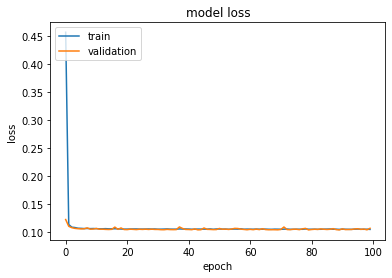

0.9744392032899065
0.9225195443826308


In [155]:
plot_curve(history)
RMSE, R2 = evaluate(base_model, X_test, Y_test)
RMSE_base_model, R2_base_model = evaluate(base_model, X_limited_test,Y_limited_test)
print(R2)
print(R2_base_model)

## 5.6 Transfer features and Fine Tune Base Model on Limited Dataset

In [156]:

fine_tuned_model = fine_tune(base_model,huber_loss)
# X_limited,Y_limited = prepare_data(envimet)
history = fine_tuned_model.fit(X_limited_train,Y_limited_train, epochs=100, verbose=0)

## 5.7 Evaluate Fine-tuned Model on Limited Dataset

In [157]:
RMSE_fine_tune ,R2_fine_tune= evaluate(fine_tuned_model,X_limited_test,Y_limited_test)
print(R2_fine_tune)

0.9655515485952206


## 5.8 Implement for all Buildings and report score

In [13]:
from IPython.display import display
def model_multiple():
    ### Create dataframe and add building names ###
    rf_bld_scores = pd.DataFrame(columns = {"bldgname", "R2_score_base_model","RMSE_score_base_model", "R2_score_finetuned_model","RMSE_score_finetuned_model"})
    for i in range(len(Bldg_Lim)):
        rf_bld_scores = rf_bld_scores.append({'bldgname': Bldg_Lim[i]['bldgname'].unique()[0]}, ignore_index=True)
    rf_bld_scores.fillna(5)
    ### Append scores to all buildings ###
    for i in range(len(Bldg_Lim)):
        # drop na values if in dataframe
        if (Bldg_Lim[i].isnull().values.any() == True):
            Bldg_Lim[i] = Bldg_Lim[i].dropna()
        building_name = Bldg_Lim[i]['bldgname'][0] 
        print("Train model for "+ building_name )
        # Limited Data
        X_limited,Y_limited = prepare_data(Bldg_Lim[i])
        X_limited_train, X_limited_test, Y_limited_train,Y_limited_test = train_test_split(X_limited,Y_limited , test_size=0.1, random_state=20)
        #Big Data
        X,Y = prepare_data(Bldg_Big[i])
        X_train, X_test, Y_train,Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)
        base_model = define_model('relu',3, huber_loss_mean)
        print("Train model for "+ building_name +" Big Data" )
        history_base = base_model.fit(X_train, Y_train, batch_size=128, epochs=100, verbose=0, validation_split=0.2)
        RMSE, R2 = evaluate(base_model, X_test, Y_test)
        RMSE_base_model, R2_base_model = evaluate(base_model, X_limited_test,Y_limited_test)
        rf_bld_scores["R2_score_base_model"][i] = R2_base_model
        rf_bld_scores["RMSE_score_base_model"][i] = RMSE_base_model   
        fine_tuned_model = fine_tune(base_model,huber_loss_mean)
        print("Train model for "+ building_name +" Limited Data" )
        history_fine_tune = fine_tuned_model.fit(X_limited_train,Y_limited_train, epochs=50, verbose=0)
        RMSE_fine_tune ,R2_fine_tune= evaluate(fine_tuned_model,X_limited_test,Y_limited_test)
        rf_bld_scores["R2_score_finetuned_model"][i] = R2_fine_tune
        rf_bld_scores["RMSE_score_finetuned_model"][i] = RMSE_fine_tune
        rf_bld_scores= rf_bld_scores[["bldgname", "R2_score_base_model","RMSE_score_base_model", "R2_score_finetuned_model","RMSE_score_finetuned_model"]]
    return rf_bld_scores
multiple_bldg_scores = model_multiple()
display(multiple_bldg_scores)

Train model for Goldwater
Train model for Goldwater Big Data
Train model for Goldwater Limited Data
Train model for Bulldog Hall
Train model for Bulldog Hall Big Data
Train model for Bulldog Hall Limited Data
Train model for ISTB 2
Train model for ISTB 2 Big Data
Train model for ISTB 2 Limited Data
Train model for Psychology North
Train model for Psychology North Big Data
Train model for Psychology North Limited Data
Train model for Schwada COB
Train model for Schwada COB Big Data
Train model for Schwada COB Limited Data
Train model for Biodesign C
Train model for Biodesign C Big Data
Train model for Biodesign C Limited Data
Train model for Biodesign A
Train model for Biodesign A Big Data
Train model for Biodesign A Limited Data
Train model for Psychology
Train model for Psychology Big Data
Train model for Psychology Limited Data
Train model for Biodesign B
Train model for Biodesign B Big Data
Train model for Biodesign B Limited Data
Train model for Noble Library
Train model for Noble 

,bldgname,R2_score_base_model,RMSE_score_base_model,R2_score_finetuned_model,RMSE_score_finetuned_model
0,Goldwater,0.931122,0.27306,0.967939,0.186298
1,Bulldog Hall,0.522527,0.707748,0.599835,0.647923
2,ISTB 2,0.854834,0.394397,0.91791,0.296584
3,Psychology North,0.686708,0.55346,0.856881,0.374076
4,Schwada COB,0.843894,0.42265,0.9024,0.334192
5,Biodesign C,0.47775,0.73282,0.836185,0.410425
6,Biodesign A,0.787245,0.463889,0.869345,0.363527
7,Psychology,0.792377,0.445067,0.901481,0.306582
8,Biodesign B,0.885236,0.35123,0.954089,0.22215
9,Noble Library,0.551427,0.694863,0.741218,0.527775


<!-- Which buildings are we training for? To be decided depending on results  -->
<!-- Train for all buildings automatically and report the scores for base_model and fine_tuned_model. -->
<!-- What scores is RF reporting? RF reports the R2 score. Add R2 score to evaluators. Create a list for evaluating and then visualise it. Not a great score, needs improvements.  -->
<!-- How to visualise the results? Made comparison matrix for now -->
<!-- How to improve the results? Experiment with loss function -->
<!-- Automate model selection: run over iterations of activation function, number of hidden layers, loss function  -->
lr scheduler
Change Y to y everywhere(Regression problem)
Add functionality to pass building names which we want to model